In [1]:
#imports
import nest
import yaml
import nest.raster_plot
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import spectrogram, butter, filtfilt
from analysis_functions import *
from asserting_functions import *


              -- N E S T --
  Copyright (C) 2004 The NEST Initiative

 Version: 3.3
 Built: Nov  6 2022 20:22:08

 This program is provided AS IS and comes with
 NO WARRANTY. See the file LICENSE for details.

 Problems or suggestions?
   Visit https://www.nest-simulator.org

 Type 'nest.help()' to find out more about NEST.



In [27]:
# Simulation parameters
brain_state = "awake"
#brain_state = "NREM"

from_file_num_exc_pop=True
if from_file_num_exc_pop == False:
    num_exc_pop = 4

debug_mode = True
high_noise = True

#define nest sim parameters
sim_pms = {"stop_ms":15000.0,
           "resolution_ms":0.1}

default_recording=False
if default_recording:
    start_recording_ms=000.0
    stop_recording_ms=sim_pms["stop_ms"]
else:
    start_recording_ms=5000.0
    stop_recording_ms=sim_pms["stop_ms"]

#save and check recording parameters
recording_pms = {"start_ms":start_recording_ms, 
                 "stop_ms":stop_recording_ms}

assert(recording_pms["start_ms"]>=0.0)
assert(recording_pms["stop_ms"]<=sim_pms["stop_ms"])     

# Load neural parameters from a YAML file
with open("neural_params.yaml", 'r') as file:
    params = yaml.safe_load(file)
    
exc_pms = params['excitatory']
inh_pms = params['inhibitory']
print("inh_pms b",inh_pms['b'])
exc_t_ref_ms=0.0


inh_pms b 0


In [28]:
# Load network parameters from YAML file
with open("network_params.yaml", 'r') as file:
    config = yaml.safe_load(file)

# Extract configurations
#brain_state = config['brain_state']
network = config['network']
weights = config['weights']
poisson = config['poisson']
dc_exc = config['dc_exc']
dc_inh = config['dc_inh']

if from_file_num_exc_pop==True:
    num_exc_pop=network['num_exc_pop']
    
num_exc_neu_per_pop=network['num_exc_neu_per_pop']
# Calculate number of inhibitory neurons based on excitatory populations and neurons per pop
network['num_inh_neu'] = int(network['num_exc_pop'] * network['num_exc_neu_per_pop'] / 4)
num_inh_neu = network['num_inh_neu']

#setting a minimum sinaptic delay if exc_t_ref_ms<=2.0
min_syn_delay_ms = 3.0 if exc_t_ref_ms else 0.0

In [29]:
use_recurrency = network["use_recurrency"]
if use_recurrency:
    if brain_state == "awake":
        weights=weights['awake']
    else:
        weights=weights['NREM']                   
    recurrent_weight = weights['recurrent_weight'] if use_recurrency else 0.0
    inh_to_exc_weight = weights["inh_to_exc_weight"]
    exc_to_inh_weight = weights["exc_to_inh_weight"]
    inh_to_inh_weight = weights["inh_to_inh_weight"]  

In [30]:
use_poisson_generators = network["use_poisson_generators"]
if use_poisson_generators:
    num_poisson_generators=network["num_poisson_generators"]
    # Set stimulation parameters based on brain state
    if brain_state == "awake":
        poisson=poisson['awake']
    else:
        if brain_state == "NREM":
            poisson=poisson['NREM']
        else:
            assert(false==true)
    poisson_spreading_factor=poisson['poisson_noise_spreading_factor']
    poisson_rate = poisson['poisson_basic_rate']/ poisson_spreading_factor
    poisson_weight = poisson['poisson_weight'] * poisson_spreading_factor
    poisson_delta = poisson["poisson_delta"]

# Create rate arrays for Poisson generators
#poisson_rate_arrays = [poisson_rate + i * poisson_delta for i in range(network["num_exc_neu_per_pop"])]
#print("number of poisson generators",len(poisson_rate_arrays))

In [31]:
#dc inhjectors to excitatory neurons
use_dc_exc_injectors = network["use_dc_exc_injectors"]
if use_dc_exc_injectors: 
    dc_exc_amplitudes = dc["amplitudes"]
    dc_exc_weight = dc["weight"]
    dc_exc_delay = dc["delay"]
    dc_exc_start = 0.0
    dc_exc_stop = sim_pms["stop_ms"]

#dc inhjectors to inhibitory neurons
use_dc_inh_injector = network["use_dc_inh_injector"]  # DC injection for inhibitory neurons
if use_dc_inh_injector:
    dc_inh_amplitude = dc_inh["amplitude"] # DC amplitude for inhibitory neurons
    dc_inh_weight = dc_inh["weight"]
    dc_inh_delay = dc_inh["delay"]
    dc_inh_start = 0.0
    dc_inh_stop = sim_pms["stop_ms"]

In [32]:


#derived values and checks before starting simulation
recording_pms["duration_ms"]=(recording_pms["stop_ms"]-recording_pms["start_ms"])
check_sim_recording_pms(sim_pms,recording_pms)

exc_neu_params={
            "a": exc_pms['a'],
            "b": exc_pms['b_awake'] if brain_state == "awake" else exc_pms['b_sleep'],
            "t_ref": exc_pms['t_ref'],
            "Delta_T": exc_pms['Delta_T'],
            "C_m": exc_pms['C_m'],
            "g_L": exc_pms['g_L'],
            "E_L": exc_pms['E_L_awake'] if brain_state == "awake" else exc_pms['E_L_sleep'],
            "V_reset": exc_pms['V_reset_awake'] if brain_state == "awake" else exc_pms['V_reset_sleep'],
            "tau_w": exc_pms['tau_w'],
            "V_th": exc_pms['V_th'],
            "V_peak": exc_pms['V_peak'],
        }


inh_neu_params={
        "a": inh_pms['a'],
        "b": inh_pms['b'],
        "t_ref": inh_pms['t_ref'],
        "Delta_T": inh_pms['Delta_T'],
        "C_m": inh_pms['C_m'],
        "g_L": inh_pms['g_L'],
        "E_L": inh_pms['E_L'],
        "V_reset": inh_pms['V_reset'],
        "tau_w": inh_pms['tau_w'],
        "V_th": inh_pms['V_th'],
        "V_peak": inh_pms['V_peak'],
    }

print("Brain State", brain_state)
print("Recurrency", use_recurrency)
print("Recurrent exc to exc weight", recurrent_weight)
print("inh_to_exc weight", inh_to_exc_weight)
print("exc_to_inh weight", exc_to_inh_weight)
print("inh_to_inh_weight", inh_to_inh_weight)
print("Poisson Speading factor", poisson_spreading_factor)
print("Spreaded poisson rate:", poisson_rate)
print("Spreaded poisson weight:", poisson_weight)
print("exc_neu_params",exc_neu_params)
print("inh_neu_params",inh_neu_params)
print("num_exc_pop", num_exc_pop)
print("num_exc_neu_per_pop", num_exc_neu_per_pop)
print("num_inh_neu", num_inh_neu)
print("num_poisson_generators", num_poisson_generators)


Brain State awake
Recurrency True
Recurrent exc to exc weight 9.5
inh_to_exc weight -0.85
exc_to_inh weight 7.0
inh_to_inh_weight -1.0
Poisson Speading factor 4.0
Spreaded poisson rate: 150.0
Spreaded poisson weight: 2.4
exc_neu_params {'a': 0, 'b': 40.0, 't_ref': 0.0, 'Delta_T': 2.0, 'C_m': 200.0, 'g_L': 10.0, 'E_L': -63.0, 'V_reset': -65.0, 'tau_w': 500.0, 'V_th': -50.0, 'V_peak': -40.0}
inh_neu_params {'a': 0, 'b': 0, 't_ref': 0.0, 'Delta_T': 2.0, 'C_m': 50.0, 'g_L': 5.0, 'E_L': -63.0, 'V_reset': -65.0, 'tau_w': 500.0, 'V_th': -50.0, 'V_peak': -40.0}
num_exc_pop 4
num_exc_neu_per_pop 20
num_inh_neu 20
num_poisson_generators 20


In [33]:
#Creation of actual simulation starts herefrom
nest.ResetKernel()

nest.SetKernelStatus({"resolution": sim_pms["resolution_ms"]})

# Create excitatory neuron populations
neurons = [
    nest.Create(
        "aeif_cond_alpha",
        num_exc_neu_per_pop,
        params=exc_neu_params,
    )
    for _ in range(num_exc_pop)
]

# Create inhibitory neurons
inh_neurons = nest.Create(
    "aeif_cond_alpha",
    num_inh_neu,
    params=inh_neu_params,
)


Apr 29 01:20:29 SimulationManager::set_status [Info]: 
    Temporal resolution changed from 0.1 to 0.1 ms.


In [34]:
# Spike recorders for excitatory and inhibitory populations
spike_recorders = [nest.Create("spike_recorder",
                               {"start": recording_pms["start_ms"], "stop": recording_pms["stop_ms"]}) 
                   for _ in range(num_exc_pop)]
inh_spike_recorder = nest.Create("spike_recorder", {"start": recording_pms["start_ms"], "stop": recording_pms["stop_ms"]})

# Connection specifications
if use_recurrency:
    exc_to_exc_delay_ms = min_syn_delay_ms + exc_t_ref_ms + 1.0
    inh_to_inh_delay_ms = min_syn_delay_ms + exc_t_ref_ms + 1.0
    conn_spec_dict = {"rule": "all_to_all", "allow_autapses": False}
    for i in range(num_exc_pop):
        nest.Connect(neurons[i], neurons[i], conn_spec_dict, syn_spec={"weight": recurrent_weight, "delay": exc_to_exc_delay_ms})
    nest.Connect(inh_neurons, inh_neurons, conn_spec_dict, syn_spec={"weight": inh_to_inh_weight, "delay": inh_to_inh_delay_ms})

# Connect inhibitory neurons to all excitatory neurons and vice versa
inh_to_exc_delay_ms = min_syn_delay_ms + exc_t_ref_ms + 0.55
exc_to_inh_delay_ms = min_syn_delay_ms + 0.5
for pop in neurons:
    nest.Connect(inh_neurons, pop, {"rule": "all_to_all"}, syn_spec={"weight": inh_to_exc_weight, "delay": inh_to_exc_delay_ms})
    nest.Connect(pop, inh_neurons, {"rule": "all_to_all"}, syn_spec={"weight": exc_to_inh_weight, "delay": exc_to_inh_delay_ms})

# Create and connect Poisson generators if enabled
if use_poisson_generators:
    pgs = nest.Create("poisson_generator", num_poisson_generators, params={"rate": poisson_rate})
    for i in range(num_exc_pop):
        nest.Connect(pgs, neurons[i], syn_spec={"weight": poisson_weight, "delay": 1.0})

# DC current injection for all neurons if enabled
if use_dc_exc_injectors:
    dcgs = [nest.Create("dc_generator", 1, {"start": dc_exc_start, "stop": dc_exc_stop, "amplitude": amp}) for amp in dc_exc_amplitudes]
    for i in range(num_exc_pop):
        nest.Connect(dcgs[i], neurons[i], syn_spec={'weight': dc_exc_weight, 'delay': dc_exc_delay})

# Specific DC current injection for inhibitory neurons
if use_dc_inh_injector:
    dc_inh_generator = nest.Create("dc_generator", 1, {"start": dc_inh_start, "stop": dc_inh_stop, "amplitude": dc_inh_amplitude})
    nest.Connect(dc_inh_generator, inh_neurons, syn_spec={'weight': dc_inh_weight, 'delay': dc_inh_delay})

# Connect spike detectors
for i in range(num_exc_pop):
    nest.Connect(neurons[i], spike_recorders[i])
nest.Connect(inh_neurons, inh_spike_recorder)

# Run the simulation
nest.Simulate(sim_pms["stop_ms"])


Apr 29 01:20:29 NodeManager::prepare_nodes [Info]: 
    Preparing 126 nodes for simulation.

Apr 29 01:20:29 SimulationManager::start_updating_ [Info]: 
    Number of local nodes: 126
    Simulation time (ms): 15000
    Number of OpenMP threads: 1
    Not using MPI

Apr 29 01:21:00 SimulationManager::run [Info]: 
    Simulation finished.


In [35]:
d_inh = nest.GetStatus(inh_spike_recorder, "events")[0]

In [36]:
#in debug_mode giving a first look before starting the analysis
def preliminary_sim_look(debug_mode,recording_pms):
    if debug_mode:
        total_exc_pop_spikes = [[0] for i in range(num_exc_pop)] 
        average_exc_pop_firing_rate_Hz = [[0] for i in range(num_exc_pop)]
        for i in range(num_exc_pop):
            d = nest.GetStatus(spike_recorders[i], "events")[0]
            print("pop", i, "first recorded event at time", d["times"][0],"from sender",d["senders"][0])
            print("pop", i, "last recorded event at time", d["times"][-1],"from sender",d["senders"][-1])
            total_exc_pop_spikes[i]=len(d["times"])
            print("pop",i, "total_exc_pop_spikes=", total_exc_pop_spikes[i])
            average_exc_pop_firing_rate_Hz[i]=\
              (total_exc_pop_spikes[i]/num_exc_neu_per_pop) * (1000.0 / recording_pms["duration_ms"]) #1000 ms in one s 
            print("pop", i, "average_exc_pop_firing_rate_Hz=", average_exc_pop_firing_rate_Hz[i],"Hz")
        d_inh = nest.GetStatus(inh_spike_recorder, "events")[0]
        print("INHIBITORIES", i, "first recorded event at time", d_inh["times"][0],"from sender",d_inh["senders"][0])
        print("INHIBITORIES", i, "last recorded event at time", d_inh["times"][-1],"from sender",d_inh["senders"][-1])
        total_inh_spikes=len(d_inh["times"])
        print("INHIBITORIES",i, "total_inh_pop_spikes=", total_inh_spikes)
        average_inh_firing_rate_Hz=\
            (total_inh_spikes/num_inh_neu) * (1000./recording_pms["duration_ms"]) #1000 ms in one s 
        print("INHIBITORIES", i, "average_inh_firing_rate_Hz=", average_inh_firing_rate_Hz,"Hz")   
        
preliminary_sim_look(debug_mode,recording_pms)   

pop 0 first recorded event at time 5065.5 from sender 3
pop 0 last recorded event at time 14850.1 from sender 20
pop 0 total_exc_pop_spikes= 873
pop 0 average_exc_pop_firing_rate_Hz= 4.365 Hz
pop 1 first recorded event at time 5007.0 from sender 32
pop 1 last recorded event at time 14962.9 from sender 39
pop 1 total_exc_pop_spikes= 882
pop 1 average_exc_pop_firing_rate_Hz= 4.41 Hz
pop 2 first recorded event at time 5000.7 from sender 43
pop 2 last recorded event at time 14992.300000000001 from sender 41
pop 2 total_exc_pop_spikes= 890
pop 2 average_exc_pop_firing_rate_Hz= 4.45 Hz
pop 3 first recorded event at time 5060.0 from sender 64
pop 3 last recorded event at time 14962.1 from sender 62
pop 3 total_exc_pop_spikes= 890
pop 3 average_exc_pop_firing_rate_Hz= 4.45 Hz
INHIBITORIES 3 first recorded event at time 5007.5 from sender 81
INHIBITORIES 3 last recorded event at time 14963.5 from sender 100
INHIBITORIES 3 total_inh_pop_spikes= 5740
INHIBITORIES 3 average_inh_firing_rate_Hz= 28.

In [37]:
def crop_events_from_spike_recorders(crop_pms, spike_recorders):
    cropped_events = []  # Initialize an empty list to hold the cropped events for each recorder
    for recorder in spike_recorders:
        # Get events for the current recorder
        recorder_events = nest.GetStatus(recorder, "events")[0]
        spike_times = recorder_events["times"]
        spike_senders = recorder_events["senders"]
        
        # Filter events based on the specified crop start and stop times
        cropped_indices = [i for i, time in enumerate(spike_times) if crop_pms["start_ms"] <= time <= crop_pms["stop_ms"]]
        cropped_times = [spike_times[i] for i in cropped_indices]
        cropped_senders = [spike_senders[i] for i in cropped_indices]
        
        # Append the cropped events for the current recorder to the list
        cropped_events.append({
            "times": cropped_times,
            "senders": cropped_senders
        })
      
    return cropped_events

def crop_inh_events(crop_pms, inh_spike_recorder):
    cropped_events = []  # Initialize an empty list to hold the cropped events for each recorder
    recorder_events = nest.GetStatus(inh_spike_recorder, "events")[0]
    spike_times = recorder_events["times"]
    spike_senders = recorder_events["senders"]
        
    # Filter events based on the specified crop start and stop times
    cropped_indices = [i for i, time in enumerate(spike_times) if crop_pms["start_ms"] <= time <= crop_pms["stop_ms"]]
    cropped_times = [spike_times[i] for i in cropped_indices]
    cropped_senders = [spike_senders[i] for i in cropped_indices]
        
    # Append the cropped events for the current recorder to the list
    cropped_events.append({
            "times": cropped_times,
            "senders": cropped_senders
        })
    return cropped_events


In [38]:
#setting the analysis parameters
default_analysis=False

if default_analysis:
    crop_start_ms=recording_pms["start_ms"] 
    crop_stop_ms=recording_pms["stop_ms"] 
else:
    crop_start_ms=5000.0
    crop_stop_ms=15000.0

crop_pms={"start_ms":crop_start_ms, 
          "stop_ms":crop_stop_ms}
crop_pms["duration_ms"]=crop_pms["stop_ms"]-crop_pms["start_ms"]

default_spectral_analysis=True

if default_spectral_analysis:
    spectrogram_window_ms=crop_pms["duration_ms"]/2
else:
    #spectrogram_window_ms=(crop_stop_ms-crop_start_ms)/2
    spectrogram_window_ms=10000.0
    
sampling_pms={"spikes_sampling_window_ms": 0.2 if brain_state=="awake" else 0.2,
              "spectrogram_window_ms":spectrogram_window_ms if brain_state=="awake" else spectrogram_window_ms,
              "low_freq_sampling_window_ms":12.5}
assert(sampling_pms["spectrogram_window_ms"]<=crop_pms["duration_ms"])

analysis_pms={}                                 
analysis_pms.update(derive_analysis_pms_from_sampling_pms(sampling_pms))
  
#assertions on crop, recording and spectrogram params
check_analysis_pms(crop_pms,recording_pms,analysis_pms)

# Assuming spike_recorders is a list of spike recorder IDs previously created in your NEST simulation
cropped_events = crop_events_from_spike_recorders(crop_pms, spike_recorders)
"""
print("type of cropped_events",type(cropped_events), len(cropped_events))
print(cropped_events)
"""
cropped_inh_events = crop_inh_events(crop_pms, inh_spike_recorder)
"""
print("type of cropped_inh_events",type(cropped_inh_events), len(cropped_inh_events))
print(cropped_inh_events)
"""
#print the set of analysis parameters
analysis_pms_print(recording_pms,crop_pms,analysis_pms)

---RECORDING INTERVAL---
start recording at time 5000.0 ms
stop recording at time 15000.0 ms
recording_duration 10000.0 ms
---CROPPING INTERVAL
crop start at time 5000.0 ms
crop stop at time 15000.0 ms
crop duration 10000.0 ms
---HIGH FREQ analysis AND (spikes) 
lower_detectable_frequency 0.2 Hz
spikes sampling window 0.2 ms
analysis sampling freq 5000.0 Hz
max nyquist frequency 2500.0 Hz
spectogram window 5000.0 ms
----LOW FREQ analysis (ECG, LFP like)
lower_detectable_frequency 0.2 Hz
low freq sampling window 12.5 ms
low freq sampling freq 80.0 Hz
(low_freq) max nyquist frequency 40.0 Hz
(low freq) spectrogram window 5000.0 ms


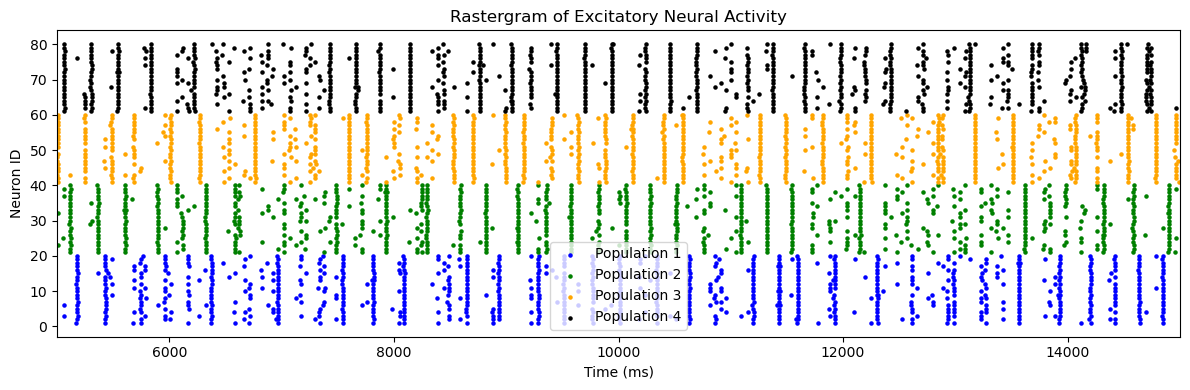

In [39]:
#plot of the rastegram of excitatory neurons
exc_pops_rastegram_plot(cropped_events,num_exc_pop, crop_pms)

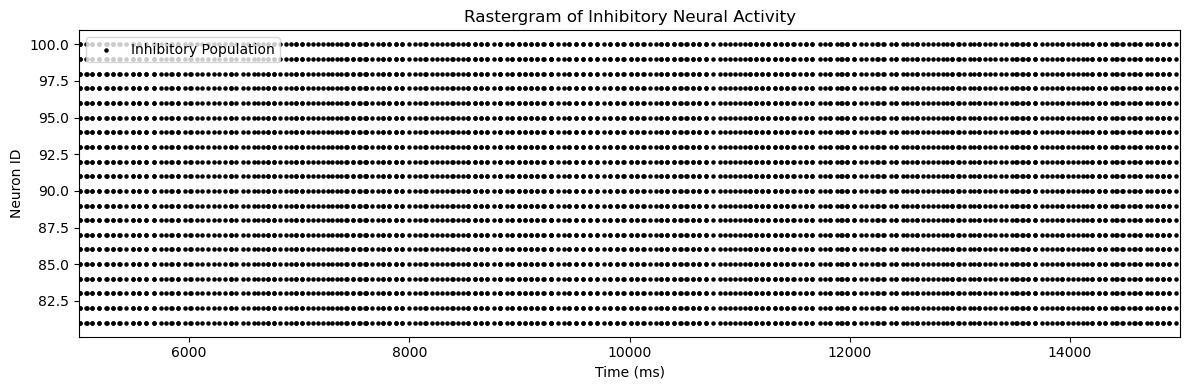

In [40]:
#plot of the rastegram of inhibitory neurons
inh_rastergram_plot(cropped_inh_events, crop_pms)

sampling_rate_Hz 5000.0
duration_ms 4.0
std_dev_ms 0.5
len of kernel 20


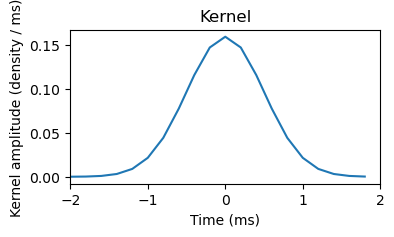

In [41]:
#preparing to smooth the single spike with the form of a spike event
sampling_rate_Hz = analysis_pms["analysis_sampling_freq_Hz"] #Hz sampling rate
print("sampling_rate_Hz", sampling_rate_Hz)
duration_ms = 4.0 # Duration of smoothing effect ms
print("duration_ms", duration_ms)
std_dev_ms = 0.5  # Standard deviation in ms
print("std_dev_ms", std_dev_ms)

single_spike_kernel = gaussian_kernel(duration_ms, sampling_rate_Hz, std_dev_ms)
print("len of kernel",len(single_spike_kernel))

kernel_plot(single_spike_kernel, sampling_rate_Hz)

In [42]:
#collect spike spikes from all populations in a single vector 
single_trace_spike_times = combine_spike_times_in_single_trace(cropped_events, network['num_exc_pop'])

In [43]:
#Calculate combined firing rates
time_points, combined_firing_rate = \
    calculate_firing_rate(crop_pms, analysis_pms, single_trace_spike_times, network['num_exc_pop']*network['num_exc_neu_per_pop'])

In [44]:
instantaneous_firing_rate_plot=False
if instantaneous_firing_rate_plot:
    #plot of combined instantaneous firing rates   
    firing_rates_plot(time_points, combined_firing_rate, crop_pms) 

len of smoothed signal 49999
type of smoothed signal <class 'numpy.ndarray'>


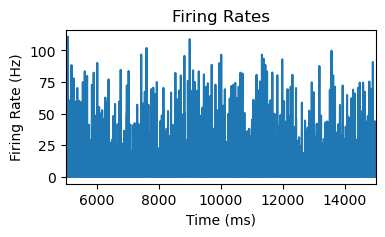

In [45]:
smoothed_spikes_firing_rate = smooth_signal(combined_firing_rate, single_spike_kernel)
print("len of smoothed signal", len(smoothed_spikes_firing_rate))
print("type of smoothed signal", type(smoothed_spikes_firing_rate))
firing_rates_plot(time_points, smoothed_spikes_firing_rate, crop_pms) 

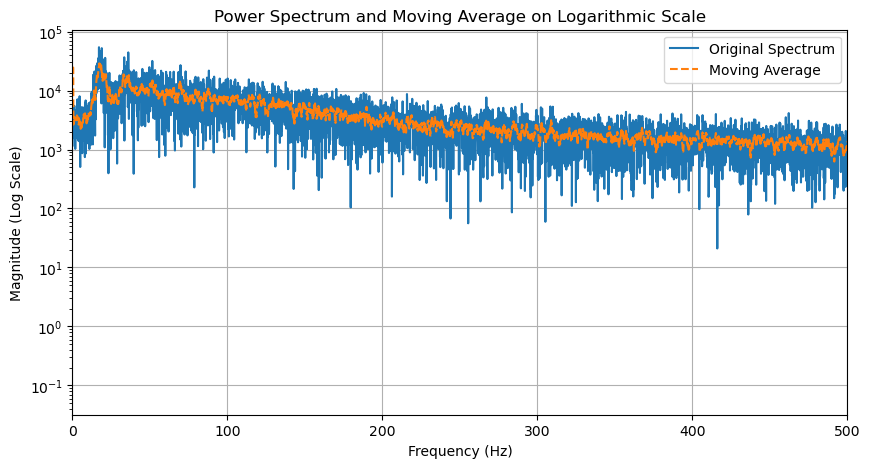

max of fft at 17.100342006840137


In [46]:
full_spectrum_preview=True
max_freq_plot_Hz = 500
assert(max_freq_plot_Hz <= sampling_rate_Hz/2)

if full_spectrum_preview:
    averaging_freq_window_size_Hz = 10 #Hz

    compute_and_plot_spectrum_with_moving_average(smoothed_spikes_firing_rate, sampling_rate_Hz, averaging_freq_window_size_Hz, max_freq_plot_Hz)
    #compute_and_plot_spectrum_with_moving_average(combined_firing_rate, sampling_rate_Hz, averaging_freq_window_size_Hz, max_freq_plot_Hz)


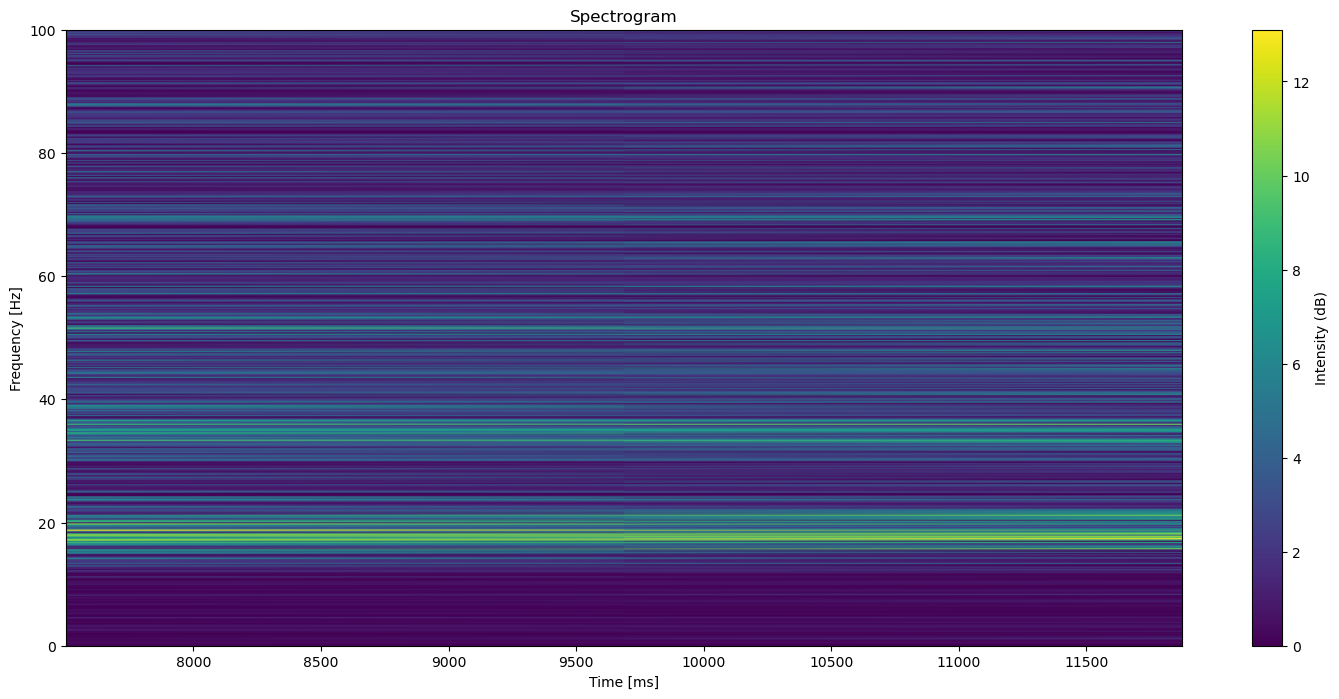

In [47]:
max_plot_freq_Hz=100
#Spectrogram plot
plot_spectrogram(time_points[0],\
                 smoothed_spikes_firing_rate,\
                 analysis_pms,max_plot_freq_Hz)

#Spectrogram plot
#plot_spectrogram(time_points[0], combined_firing_rate, analysis_pms)

sampling_rate_Hz 5000.0
duration_ms 500.0
std_dev_ms 12.5
len of kernel 2500


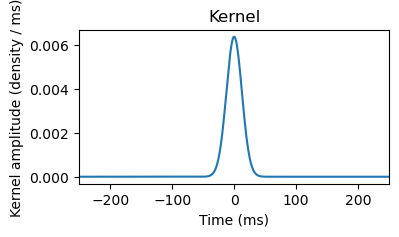

In [48]:
#downsampling for low frequency analysis
#preparing to smooth the spike gaussians with synaptic times for ECG/LFP/ECoG like analysis
sampling_rate_Hz = analysis_pms["analysis_sampling_freq_Hz"] #Hz sampling rate
print("sampling_rate_Hz", sampling_rate_Hz)
duration_ms = 500.0 # Duration of smoothing effect ms
print("duration_ms", duration_ms)
std_dev_ms = 12.5  # Standard deviation in ms
print("std_dev_ms", std_dev_ms)
tissue_response_kernel = gaussian_kernel(duration_ms, sampling_rate_Hz, std_dev_ms)
print("len of kernel",len(tissue_response_kernel))

kernel_plot(tissue_response_kernel, sampling_rate_Hz)

In [49]:
#smoothed_spikes_firing_rate = smooth_signal(combined_firing_rate, single_spike_kernel)
tissue_response_rate = smooth_signal(smoothed_spikes_firing_rate, tissue_response_kernel)

In [50]:
if len(tissue_response_rate)<=1000:
    print("len of tissue signal", len(tissue_response_rate))
    print("type of tissue signal", type(tissue_response_rate))
    firing_rates_plot(time_points, tissue_response_rate, crop_pms) 

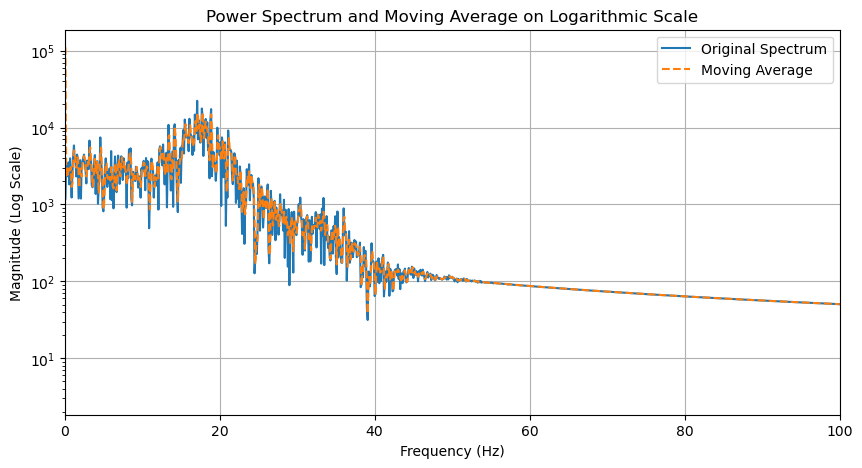

max of fft at 17.100342006840137


In [51]:
full_spectrum_preview=True
if full_spectrum_preview:
    averaging_freq_window_size_Hz = 2 #Hz
    max_freq_plot_Hz = 100 #Hz
    compute_and_plot_spectrum_with_moving_average(tissue_response_rate, sampling_rate_Hz, averaging_freq_window_size_Hz, max_freq_plot_Hz)
    #compute_and_plot_spectrum_with_moving_average(combined_firing_rate, sampling_rate_Hz, averaging_freq_window_size_Hz, max_freq_plot_Hz)


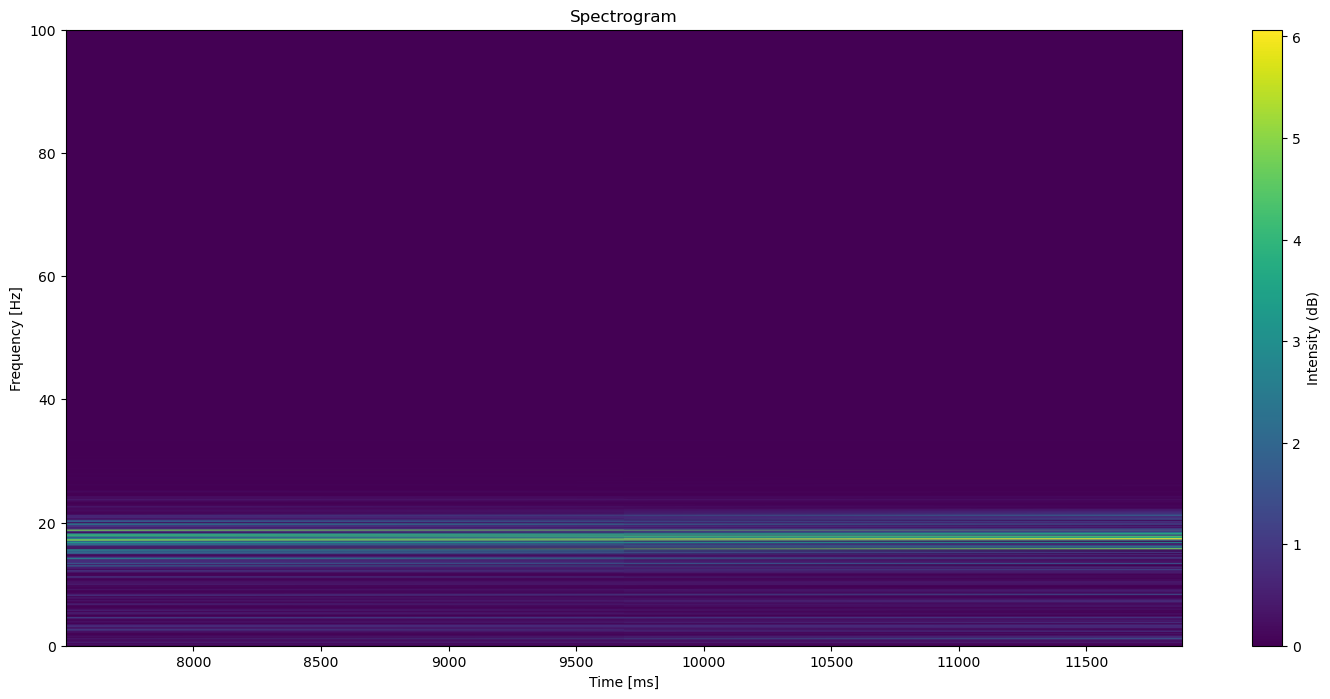

In [52]:
max_plot_freq_Hz=100
#Spectrogram plot
plot_spectrogram(time_points[0],\
                 tissue_response_rate,\
                 analysis_pms,max_plot_freq_Hz)

#Spectrogram plot
#plot_spectrogram(time_points[0], combined_firing_rate, analysis_pms)